In [1]:

%pip install numpy==1.26.4
%pip install pandas==2.2.1
# %pip install tensorflow[and-cuda]==2.15.1
%pip install tf-agents[reverb]==0.19.0

%pip install yfinance==0.2.37
%pip install ta==0.11.0
%pip install pandas_market_calendars
%pip install pyarrow==11.0.0

%pip install tqdm
%pip install scikit-learn
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.2 which is incompatible.
cudf 23.8.0 

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents

import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    from google.colab import files
    from google.colab import drive

    IN_COLAB = True
    GDRIVE = '/content/drive'
    drive.mount(GDRIVE)
    print("Mounted on COLLAB")
except:
    GDRIVE = None
    IN_COLAB = False
    files = None
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle...')

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/futures"
    IN_KAGGLE = True
else:
    IN_KAGGLE = False
    DATA_DIR = "./data/"

Running in Kaggle...


In [3]:
import tensorflow as tf
import tf_agents as tfa

from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import sequential
from tf_agents.metrics import py_metrics, tf_metrics
from tf_agents.policies import greedy_policy, py_tf_eager_policy, random_py_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils, py_uniform_replay_buffer, tf_uniform_replay_buffer
from tf_agents.train import learner, triggers
from tf_agents.train.utils import spec_utils, strategy_utils, train_utils
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.policies import random_py_policy, py_tf_eager_policy, policy_saver, random_tf_policy
from tf_agents.eval import metric_utils
from tf_agents.drivers import py_driver, dynamic_episode_driver, dynamic_step_driver

import numpy as np
import math
import shutil
import yfinance as yf
import pandas as pd
import IPython
import pyarrow
import reverb

import pytz
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay, Day
from datetime import datetime
import pandas_market_calendars as mcal

from scipy.stats import skew, kurtosis
from ta.utils import dropna
from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if ('COLAB_TPU_ADDR' in os.environ and IN_COLAB) or (IN_KAGGLE and 'TPU_ACCELERATOR_TYPE' in os.environ):
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
elif len(tf.config.list_physical_devices('GPU')) > 0:
    strategy = tf.distribute.MirroredStrategy()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("Number of accelerators:", strategy.num_replicas_in_sync)

os.getcwd()

2024-03-27 05:56:03.614966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 05:56:03.615078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 05:56:03.902677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Physical devices cannot be modified after being initialized
Running on 2 GPU(s)
Number of accelerators: 2


'/kaggle/working'

In [4]:
INDEX = "Date"
MIN1_RANGE = 7 - 1
MIN15_RANGE = 60 - 1
HOUR_RANGE = 730 - 1
DAY_RANGE = 7300 - 1
D1="1d"
H1="1h"
M15="15m"
M1="1m"
EVAL_SPLIT = 0.2
DATE_TIME_FORMAT = "%Y-%m-%d"
START_DATE = "2024-02-01" #pd.Timestamp(datetime.now() - Day(MIN15_RANGE)).strftime(DATE_TIME_FORMAT)
END_DATE = "2024-03-25" #pd.Timestamp(datetime.now() - BDay(1)).strftime(DATE_TIME_FORMAT)
total_days = (pd.Timestamp(END_DATE) - pd.Timestamp(START_DATE)).days
midpoint_date = pd.Timestamp(START_DATE) + Day(int(total_days * EVAL_SPLIT))
SPLIT_DATE = pd.to_datetime(midpoint_date).tz_localize("UTC") # midpoint_date.tz_localize("UTC").strftime(DATE_TIME_FORMAT)

IS_TARGET = "tgt"
SNP_FUT = "ES=F" # E-min SnP futures
NSDQ_FUT = "NQ=F"
RUS_FUT = "RTY=F"
GOLD_FUT = "GC=F" # Gold futures
CRUDOIL_FUT="CL=F"

RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
SMALLCAP_INDEX = "^RUT" # Russell 2000 Index
GOLD_INDEX = "^SPGSGC"
MARKET = "^SPX" # SnP
TECH = "^NDX" # Nasdaq
CRUDOIL_INDEX="^SPGSCL"

TARGET1 = TECH
TARGET2 = MARKET
TARGET3 = SMALLCAP_INDEX
TICKER_SYMBOLS = [RATES_INDEX, VOLATILITY_INDEX, GOLD_INDEX, CRUDOIL_INDEX, TARGET1, TARGET2, TARGET3]

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_NEUTRAL = 3 # Added this action to go to neutral and wait
ACT_HOLD = 2
ACT_LONG = 1
ACT_SHORT = 0
ACTIONS = [ACT_SHORT, ACT_LONG]

CAPITAL = 100000
TRADE_COSTS_PERCENT = 35 / 100 / 100 # 25BPS costs

MACRO_FEATURES = [MARKET, RATES_INDEX, VOLATILITY_INDEX, GOLD_INDEX, CRUDOIL_INDEX]
TA_FEATURES = ['MACD', 'MACD_HIST', 'MACD_SIG', 'ATR']
FEATURES = ["Close", "High", "Low", "Open", "Volume"]
TARGET_FEATURE = "Price Raw"

STATE_LEN = 4 * 8 * 5
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = len(ACTIONS)

LEARN_RATE = 1e-3
TOTAL_ITERS = 40 # 20
TARGET_UPDATE = max(TOTAL_ITERS // 4, 10)
TRAIN_EPISODES = TOTAL_ITERS * 20
INIT_COLLECT = 100
COLLECT_STEPS = 1
LOG_INTERVALS = max(int(TOTAL_ITERS / 2), 2)
TEST_INTERVALS = max(int(TOTAL_ITERS / 1.5), 10)
EVAL_EPISODES = max(int(TEST_INTERVALS / 2), 10)

BATCH_SIZE = 32 * strategy.num_replicas_in_sync
MEMORY_LENGTH = 100000
DISCOUNT = .65 # Short term gains < 5 or long > 5
EPSILON_START = 1.
EPSILON_END = 0.01
EPSILON_DECAY = 75 #120.

GRAD_CLIP = 1
REWARD_CLIP = 1
PUNISHMENT = 1.05 # Increase the negative 'reward'
REWARD_SCALE = 1.0
CHECKPOINT_INTERVAL = max(TOTAL_ITERS // 5, 10)

DROPOUT = 0.5
L2FACTOR = 0.000025
NEURONS = 512
LAYERS = (NEURONS,) * 6

class StockFeat:
    DATETIME = "Datetime"
    OPEN = "Open"
    HIGH = "High"
    LOW = "Low"
    CLOSE = "Close"
    VOLUME = "Volume"
    list = [OPEN, HIGH, LOW, CLOSE, VOLUME]

class YFinanceOptions:
    INDEX = "Datetime"
    MIN1_RANGE = 7 - 1
    MIN15_RANGE = 60 - 1
    HOUR_RANGE = 730 - 1
    DAY_RANGE = 7300 - 1
    D1="1d"
    H1="1h"
    M15="15m"
    M1="1m"
    DATE_TIME_FORMAT = "%Y-%m-%d"
    DATE_TIME_HRS_FORMAT = '%Y-%m-%d %H:%M:%S'

def get_yf_tickers_df(tickers_symbols, start, end, interval=YFinanceOptions.M15, datadir="/data"):
    tickers = {}
    earliest_end= pd.to_datetime(datetime.strptime(end,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    latest_start = pd.to_datetime(datetime.strptime(start,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    os.makedirs(datadir, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
 
        if os.path.exists(cached_file_path):
            print(f"loading from {cached_file_path}")
            df = pd.read_csv(cached_file_path, parse_dates= True, index_col=0)
            df.index = pd.to_datetime(df.index).tz_localize('America/New_York').tz_convert('UTC')
            assert len(df) > 0, "Empty data"
        else:
            df = yf.download(
                symbol,
                start=start,
                end=end,
                progress=True,
                interval=interval
            )
            assert len(df) > 0, "No data pulled"
            df.index = pd.to_datetime(df.index).tz_localize('America/New_York').tz_convert('UTC')
        min_date = df.index.min()
        max_date = df.index.max()
        nan_count = df["Close"].isnull().sum()
        skewness = round(skew(df["Close"].dropna()), 2)
        kurt = round(kurtosis(df["Close"].dropna()), 2)
        outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
        print(
            f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
        )
        tickers[symbol] = df

        if min_date > latest_start:
            latest_start = min_date
        if max_date < earliest_end:
            earliest_end = max_date

    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=latest_start, end_date=earliest_end)
    all_trading_days = mcal.date_range(schedule, frequency='15T')

    for symbol, df in tickers.items():
        df_filtered = df[(df.index >= latest_start) & (df.index <= earliest_end)]
        df_reindexed = df_filtered.reindex(all_trading_days, method='nearest')
        df_reindexed.index = pd.to_datetime(df_reindexed.index)
        df_reindexed = df_reindexed[~df_reindexed.index.duplicated(keep='first')]
        tickers[symbol] = df_reindexed

        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
        if not os.path.exists(cached_file_path):
            df_reindexed.to_csv(cached_file_path, index=True)
            
    return tickers, latest_start, earliest_end

MONTH_SINE = "month_sin"
MONTH_COS = "month_cos"
DAY_SINE = "day_sin"
DAY_COS = "day_cos"
HR_SINE = "hr_sin"
HR_COS = "hr_cos"
MONTH = "m"
DAY = "d"
HR = "h"
TIME_FEATURES = [MONTH, DAY, HR] # [MONTH_SINE, MONTH_COS, DAY_SINE, DAY_COS, HR_SINE, HR_COS]

tickers, latest_start, earliest_end = get_yf_tickers_df(TICKER_SYMBOLS, start=START_DATE, end=END_DATE)

def decorate_ts(stock_df, target=False):
    def create_time_features(data_df):
        def _sin_transformer(x, period):
            return np.sin(x / period * 2 * np.pi)

        def _cos_transformer(x, period):
            return np.cos(x / period * 2 * np.pi)

        if not isinstance(data_df.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index must be a DateTimeIndex.")
    
        """
        data_df[DAY_SINE] = data_df.index.day.map(lambda x: _sin_transformer(x, 31))
        data_df[DAY_COS] = data_df.index.day.map(lambda x: _cos_transformer(x, 31))
        data_df[MONTH_SINE] = data_df.index.month.map(lambda x: _sin_transformer(x, 12))
        data_df[MONTH_COS] = data_df.index.month.map(lambda x: _cos_transformer(x, 12))
        data_df[HR_SINE] = data_df.index.hour.map(lambda x: _sin_transformer(x, 24))
        data_df[HR_COS] = data_df.index.hour.map(lambda x: _cos_transformer(x, 24))
        """
        data_df[HR] = data_df.index.hour
        data_df[DAY] = data_df.index.day
        data_df[MONTH] = data_df.index.month
        
        return data_df

    stock_df = create_time_features(stock_df)

    macd = MACD(close=stock_df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
    stock_df['MACD'] = macd.macd()
    stock_df['MACD_HIST'] = macd.macd_diff()
    stock_df['MACD_SIG'] = macd.macd_signal()

    atr = AverageTrueRange(stock_df["High"], stock_df["Low"], stock_df["Close"], window = 14, fillna = True)
    stock_df['ATR'] = atr.average_true_range()

    ema = EMAIndicator(stock_df["Close"], window = 14, fillna = True)
    stock_df['EMA'] = ema.ema_indicator()

    stock_df[MARKET] = tickers[MARKET]["Close"]
    stock_df[VOLATILITY_INDEX] = tickers[VOLATILITY_INDEX]["Close"]
    stock_df[RATES_INDEX] = tickers[RATES_INDEX]["Close"]
    stock_df[GOLD_INDEX] = tickers[GOLD_INDEX]["Close"]
    stock_df[CRUDOIL_INDEX] = tickers[CRUDOIL_INDEX]["Close"]
    stock_df[IS_TARGET] = int(target) # ID target or conditioning

    stock_df = stock_df.bfill().ffill()
    return stock_df

stock1_df = tickers[TARGET1].copy()
stock2_df = tickers[TARGET2].copy()
stock3_df = tickers[TARGET3].copy()

stock1_df = decorate_ts(stock1_df, target=True)
stock2_df = decorate_ts(stock2_df)
stock3_df = decorate_ts(stock3_df)

stock1_df

[*********************100%%**********************]  1 of 1 completed


^TNX => min_date: 2024-02-01 13:15:00+00:00, max_date: 2024-03-22 18:45:00+00:00, kurt:1.52, skewness:-1.13, outliers_count:0,  nan_count: 0


[*********************100%%**********************]  1 of 1 completed


^VIX => min_date: 2024-02-01 07:15:00+00:00, max_date: 2024-03-22 19:00:00+00:00, kurt:0.31, skewness:0.52, outliers_count:4,  nan_count: 0


[*********************100%%**********************]  1 of 1 completed


^SPGSGC => min_date: 2024-02-01 14:30:00+00:00, max_date: 2024-03-22 19:30:00+00:00, kurt:-1.62, skewness:0.33, outliers_count:0,  nan_count: 0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


^SPGSCL => min_date: 2024-02-01 14:30:00+00:00, max_date: 2024-03-22 19:30:00+00:00, kurt:0.17, skewness:-0.52, outliers_count:0,  nan_count: 0


[*********************100%%**********************]  1 of 1 completed


^NDX => min_date: 2024-02-01 14:30:00+00:00, max_date: 2024-03-22 19:45:00+00:00, kurt:-0.19, skewness:-0.33, outliers_count:0,  nan_count: 0
^SPX => min_date: 2024-02-01 14:30:00+00:00, max_date: 2024-03-22 19:45:00+00:00, kurt:-0.77, skewness:-0.09, outliers_count:0,  nan_count: 0


[*********************100%%**********************]  1 of 1 completed


^RUT => min_date: 2024-02-01 14:30:00+00:00, max_date: 2024-03-22 19:45:00+00:00, kurt:-0.74, skewness:-0.5, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume,h,d,m,MACD,MACD_HIST,MACD_SIG,ATR,EMA,^SPX,^VIX,^TNX,^SPGSGC,^SPGSCL,tgt
2024-02-01 14:45:00+00:00,17230.830078,17235.843750,17198.257812,17214.144531,17214.144531,43425150,14,1,2,0.000000,0.000000,0.000000,0.000000,17214.144531,4866.189941,14.44,3.877,1201.327759,418.776703,1
2024-02-01 15:00:00+00:00,17195.525391,17257.888672,17182.781250,17246.671875,17246.671875,42579661,15,1,2,2.594774,2.075819,0.518955,0.000000,17218.481510,4872.689941,14.59,3.886,1202.841553,421.407410,1
2024-02-01 15:15:00+00:00,17248.339844,17268.451172,17225.671875,17268.421875,17268.421875,34695100,15,1,2,6.333189,4.651387,1.681802,0.000000,17225.140226,4876.330078,14.61,3.877,1203.074341,420.256409,1
2024-02-01 15:30:00+00:00,17268.017578,17272.306641,17244.015625,17250.080078,17250.080078,33050819,15,1,2,7.726810,4.836007,2.890803,0.000000,17228.465539,4871.830078,14.29,3.865,1204.529907,419.434296,1
2024-02-01 15:45:00+00:00,17249.861328,17254.992188,17184.488281,17184.488281,17184.488281,33012254,15,1,2,3.498230,0.485941,3.012289,0.000000,17222.601905,4855.669922,14.25,3.848,1204.879272,418.064209,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 19:00:00+00:00,18358.822266,18359.888672,18347.929688,18357.558594,18357.558594,14490824,19,22,3,11.040332,2.041683,8.998649,22.957009,18352.557593,5241.790039,13.02,4.218,1270.494141,442.014587,1
2024-03-22 19:15:00+00:00,18358.822266,18359.888672,18347.929688,18357.558594,18357.558594,14490824,19,22,3,10.468934,1.176227,9.292706,22.171435,18353.224393,5241.790039,13.02,4.218,1270.494141,442.014587,1
2024-03-22 19:30:00+00:00,18358.822266,18359.888672,18347.929688,18357.558594,18357.558594,14490824,19,22,3,9.901953,0.487397,9.414555,21.441975,18353.802287,5241.790039,13.02,4.218,1270.494141,442.014587,1
2024-03-22 19:45:00+00:00,18358.822266,18359.888672,18347.929688,18357.558594,18357.558594,14490824,19,22,3,9.344894,-0.055729,9.400623,20.764618,18354.303128,5241.790039,13.02,4.218,1270.494141,442.014587,1


In [5]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES + MACRO_FEATURES + [IS_TARGET], money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT, reward_discount=DISCOUNT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = TIME_FEATURES + features
        self.data_dim = len(self.features)
        self.state_length = state_length
        self.current_step = self.state_length
        self.reward_discount = reward_discount

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length * self.data_dim, ), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def BATCH_SIZE(self):
        return None #self._batch_size

    @BATCH_SIZE.setter
    def BATCH_SIZE(self, size):
        self._BATCH_SIZE = size

    def preprocess_data(self, df):
        def _log_rets(df):
            log_returns = np.log(df / df.shift(1))
            df = (log_returns - log_returns.mean()) / log_returns.std()
            df = df.dropna()
            return df

        def min_max_scale_tensor(tensor):
            min_val = tf.reduce_min(tensor)
            max_val = tf.reduce_max(tensor)
            return (tensor - min_val) / (max_val - min_val)

        price_raw = df['Close'].copy()
        """
        for col in self.features:
            if col in TIME_FEATURES:
                continue
            tensor = tf.convert_to_tensor(df[col], dtype=tf.float32)
            normalized_tensor = min_max_scale_tensor(tensor)
            df[col] = normalized_tensor.numpy()
        """

        df = df.replace(0.0, np.nan)
        df = df.interpolate(method='linear', limit=5, limit_area='inside')
        df = df.ffill().bfill().fillna(0)

        df[TARGET_FEATURE] = price_raw
        df['Sharpe'] = 0
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Returns'] = 0.
        df['Reward'] = 0.

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = self.state_length
        self._episode_ended = False
        self.total_shares = 0

        self.data['Reward'] = 0.
        self.data['Sharpe'] = 0.
        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step and history length."""
        start_idx = max(0, self.current_step - self.state_length + 1)
        end_idx = self.current_step + 1
        obs = self.data[self.features].iloc[start_idx:end_idx]

        # flatten because: https://stackoverflow.com/questions/67921084/dqn-agent-issue-with-custom-environment
        obs_values = obs.values.flatten().astype(np.float32)
        return obs_values

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        elif action == ACT_NEUTRAL:
            self._process_neutral_position(current_price)
        else:
            raise Exception(f"Invalid Actions: {action}")

        self._update_financials()
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_simple_reward_signal()
        self.data.at[self.data.index[self.current_step], "Reward"] = reward
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=self.reward_discount)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_neutral_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
        self.data.at[step_idx, "Holdings"] = 0.0
        self.data.at[step_idx, "Position"] = 0.0
        self.data.at[step_idx, "Action"] = ACT_NEUTRAL

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        self.data.at[step_idx, 'Action'] = ACT_LONG

        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, "Action"] = ACT_HOLD
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        self.data.at[step_idx, "Action"] = ACT_SHORT
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
                self.data.at[step_idx, "Action"] = ACT_HOLD
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price

    def _update_financials(self):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]
        self.balance = self.data.iloc[self.current_step]['Cash']

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_simple_reward_signal(self, reward_clip=REWARD_CLIP):
        """
        Simplified reward function based on specified criteria.
        """
        rets = self.data.iloc[self.current_step]['Returns']

        if rets == 0:
            reward = -0.25
        elif abs(rets) <= 0.01:
            reward = 0.5 if rets > 0 else -0.5
        elif abs(rets) <= 0.1:
            reward = 0.75 if rets > 0 else -0.75
        elif abs(rets) >= 0.1:
            reward = 1 if rets > 0 else -1
        else:
            reward = 0

        return np.clip(reward, -reward_clip, reward_clip)


    def _calculate_reward_signal(self, reward_clip=REWARD_CLIP, punishment=PUNISHMENT):
        """
        Calculates the reward for the current step. In the paper they use the %returns.
        """
        reward = rets = self.data.iloc[self.current_step]['Returns']
        if rets < 0:
            reward *= punishment
            if rets < 0.5:
                # We lost 1/2 our portfolio, give max punishment
                reward *= 100
        elif rets > 0.25:
            # invert the punishment for extra reward.
            reward *= punishment
        elif rets == 0.:
            # The did nothing?
            reward = -0.1
        return np.clip(reward, -reward_clip, reward_clip)

    def _calculate_sharpe_reward_signal(self, risk_free_rate=0.05, periods_per_year=252, reward_clip=REWARD_CLIP):
        """
        Calculates the annualized Sharpe ratio up to the CURRENT STEP.

        Parameters:
        - risk_free_rate (float): The annual risk-free rate. It will be adjusted to match the period of the returns.
        - periods_per_year (int): Number of periods in a year (e.g., 252 for daily, 12 for monthly).

        Returns:
        - float: The annualized Sharpe ratio as reward.
        """
        period_risk_free_rate = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
        observed_returns = self.data['Returns'].iloc[:self.current_step + 1]

        excess_returns = observed_returns - period_risk_free_rate

        mean_excess_return = np.mean(excess_returns)
        std_dev_returns = np.std(observed_returns)

        sharpe_ratio = mean_excess_return / std_dev_returns if std_dev_returns > 0 else 0
        annual_sr = sharpe_ratio * np.sqrt(periods_per_year)

        self.data.at[self.data.index[self.current_step], 'Sharpe'] = annual_sr

        return np.clip(annual_sr, -reward_clip, reward_clip)

    def calculate_churn(self):
        churn = 0
        prev_position = 0
        for i in range(1, self.current_step + 1):
            current_position = self.data.at[self.data.index[i], 'Position']
            action = self.data.at[self.data.index[i], 'Action']
            if action in [ACT_LONG, ACT_SHORT] and current_position != prev_position:
                churn += self.transaction_cost

            prev_position = current_position

        if self.current_step > 0:
            churn /= self.current_step

        return churn

    def calculate_drawdown_metrics(self):
        rets = test_env.data['Returns'].iloc[:test_env.current_step + 1]
        cumulative_returns = (1. + rets).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak.replace(0, np.nan)
        max_dd = drawdown.replace([np.inf, -np.inf], np.nan).fillna(0).min() # max is min here.

        peak_dates = cumulative_returns[peak == cumulative_returns]
        drawdown_durations = pd.Series(index=drawdown.index, dtype='timedelta64[ns]')
        for date in drawdown.index:
            recent_peak_date = peak_dates[peak_dates.index <= date].index[-1]
            duration = date - recent_peak_date
            drawdown_durations.at[date] = duration

        drawdown_durations_days = drawdown_durations.dt.days
        max_dd_duration_days = drawdown_durations_days.max()

        return max_dd, max_dd_duration_days

    def get_trade_stats(self, riskfree_rate=0.05, periods = 252 * 4):
        rets = self.data['Returns'].iloc[:self.current_step + 1]

        annualized_return = rets.mean() * periods
        annualized_vol = rets.std() * np.sqrt(periods)

        daily_riskfree_rate = (1 + riskfree_rate)**(1/periods) - 1
        sharpe_ratio = ((rets.mean() - daily_riskfree_rate) / rets.std()) * np.sqrt(periods)

        downside_deviation = rets[rets < 0].std() * np.sqrt(periods)
        drawdowns, max_dd_duration_days = self.calculate_drawdown_metrics()

        sortino_ratio = ((rets.mean() - daily_riskfree_rate) / downside_deviation)

        churn = self.calculate_churn()

        return {
            "Annualized Return": annualized_return,
            "Annualized Vol": annualized_vol,
            "Sharpe Ratio": sharpe_ratio,
            "Downside Deviation": downside_deviation,
            "Sortino Ratio": sortino_ratio,
            "Max Drawdown": drawdowns.max(),
            "Max Drawdown Days": max_dd_duration_days,
            "Trade Churn": churn,
            "Skewness": skew(rets.values),
            "Kurtosis": kurtosis(rets.values)
        }

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.total_shares}')
        print(f"trade stats: {self.get_trade_stats()}")

train_data = stock1_df[stock1_df.index < SPLIT_DATE].copy()
test_data = stock1_df[stock1_df.index >= SPLIT_DATE].copy()
condition_data = stock2_df[stock2_df.index < SPLIT_DATE].copy()
condition2_data = stock3_df[stock3_df.index < SPLIT_DATE].copy()

train_env = TradingEnv(train_data)
utils.validate_py_environment(train_env, episodes=2)
test_env = TradingEnv(test_data)
utils.validate_py_environment(train_env, episodes=1)
condition_env = TradingEnv(condition_data)
utils.validate_py_environment(condition_env, episodes=2)
condition2_env = TradingEnv(condition2_data)
utils.validate_py_environment(condition2_env, episodes=2)

collect_env = train_env
eval_env = test_env

collect_env.data

,Open,High,Low,Close,Adj Close,Volume,h,d,m,MACD,...,tgt,Price Raw,Sharpe,Position,Action,Holdings,Cash,Money,Returns,Reward
2024-02-01 14:45:00+00:00,17230.830078,17235.843750,17198.257812,17214.144531,17214.144531,43425150,14,1,2,2.594774,...,1,17214.144531,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.00
2024-02-01 15:00:00+00:00,17195.525391,17257.888672,17182.781250,17246.671875,17246.671875,42579661,15,1,2,2.594774,...,1,17246.671875,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.00
2024-02-01 15:15:00+00:00,17248.339844,17268.451172,17225.671875,17268.421875,17268.421875,34695100,15,1,2,6.333189,...,1,17268.421875,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.00
2024-02-01 15:30:00+00:00,17268.017578,17272.306641,17244.015625,17250.080078,17250.080078,33050819,15,1,2,7.726810,...,1,17250.080078,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.00
2024-02-01 15:45:00+00:00,17249.861328,17254.992188,17184.488281,17184.488281,17184.488281,33012254,15,1,2,3.498230,...,1,17184.488281,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-09 20:00:00+00:00,17975.494141,17976.052734,17953.496094,17964.261719,17964.261719,23772070,20,9,2,38.632688,...,1,17964.261719,0.0,1,1,89821.308594,10449.375000,100270.683594,0.000541,0.50
2024-02-09 20:15:00+00:00,17964.140625,17972.269531,17957.121094,17960.853516,17960.853516,24305151,20,9,2,36.534242,...,1,17960.853516,0.0,-1,0,-89804.267578,190057.910156,100253.642578,-0.000170,-0.50
2024-02-09 20:30:00+00:00,17959.511719,17963.142578,17951.570312,17958.050781,17958.050781,31053219,20,9,2,34.250237,...,1,17958.050781,0.0,1,1,89790.253906,10477.402344,100267.656250,0.000140,0.50
2024-02-09 20:45:00+00:00,17956.980469,17966.298828,17950.904297,17958.605469,17958.605469,66898320,20,9,2,32.114706,...,1,17958.605469,0.0,-1,0,-89793.027344,190063.457031,100270.429688,0.000028,0.50


In [6]:
def create_q_network(env, fc_layer_params=LAYERS, dropout_rate=DROPOUT, l2_reg=L2FACTOR):
    """
    Creates a Q-Network with dropout and batch normalization.
    Parameters:
    - env: The environment instance.
    - fc_layer_params: Tuple of integers representing the number of units in each dense layer.
    - dropout_rate: Dropout rate for dropout layers.
    - l2_reg: L2 regularization factor.

    Returns:
    - q_net: The Q-Network model.
    """
    env = tf_py_environment.TFPyEnvironment(env)
    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    layers = []
    for num_units in fc_layer_params:
        layers.append(tf.keras.layers.Dense(
                                num_units,
                                activation=None,
                                kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
                                kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        # Internal Covariate Shift Reductio by normalizing layer inputs, this improves gradient flow.
        layers.append(tf.keras.layers.BatchNormalization())
        layers.append(tf.keras.layers.LeakyReLU())
        layers.append(tf.keras.layers.Dropout(dropout_rate))

    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.GlorotNormal(),
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    q_net = sequential.Sequential(layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, global_step = None, t_q_net = None, optimizer = None, eps=EPSILON_START, learning_rate=LEARN_RATE, gradient_clipping = GRAD_CLIP, discount=DISCOUNT):
    """
    Creates a DQN agent for a given environment with specified configurations.

    Parameters:
    - q_net (tf_agents.networks.Network): The primary Q-network for the agent.
    - env (tf_agents.environments.PyEnvironment or tf_agents.environments.TFPyEnvironment):
      The environment the agent will interact with. A TFPyEnvironment wrapper is applied
      if not already wrapped.
    - t_q_net (tf_agents.networks.Network, optional): The target Q-network for the agent.
      If None, no target network is used.
    - optimizer (tf.keras.optimizers.Optimizer, optional): The optimizer to use for training the agent.
      If None, an Adam optimizer with exponential decay learning rate is used.
    - eps (float): The epsilon value for epsilon-greedy exploration.
    - learning_rate (float): The initial learning rate for the exponential decay learning rate schedule.
      Ignored if an optimizer is provided.
    - gradient_clipping (float): The value for gradient clipping. If 1., no clipping is applied.

    Returns:
    - agent (tf_agents.agents.DqnAgent): The initialized and configured DQN agent.
    """
    if optimizer is None:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    env = tf_py_environment.TFPyEnvironment(env)
    # see: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent
    agent = dqn_agent.DdqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        gamma=discount,
        q_network=q_net,
        target_q_network = t_q_net,
        target_update_period = TARGET_UPDATE,
        optimizer=optimizer,
        epsilon_greedy = eps,
        gradient_clipping = gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=global_step,
        name="TradeAgent")

    agent.initialize()

    return agent

with strategy.scope():
    global_step = tf.compat.v1.train.get_or_create_global_step()
    q_net = create_q_network(train_env)
    t_q_net = create_q_network(train_env)
    tf_agent = create_agent(q_net, train_env, global_step=global_step, t_q_net=t_q_net)

In [7]:
def get_eval_metrics(tf_eval_env, tf_eval_policy):
    eval_metrics = [
        tf_metrics.AverageReturnMetric(buffer_size=TEST_INTERVALS + 1),
        tf_metrics.MinReturnMetric(buffer_size=TEST_INTERVALS + 1),
        tf_metrics.MaxReturnMetric(buffer_size=TEST_INTERVALS + 1),
    ]
    eval_dir = os.path.join(MODELS_PATH, 'eval')
    eval_summary_writer = tf.compat.v2.summary.create_file_writer(
        eval_dir, flush_millis=16000
    )
    results = metric_utils.eager_compute(
        eval_metrics,
        tf_eval_env,
        tf_eval_policy,
        num_episodes=EVAL_EPISODES,
        train_step=global_step,
        summary_writer=eval_summary_writer,
        summary_prefix='Metrics',
    )
    metric_utils.log_metrics(eval_metrics)
    return results

def log_eval_metrics(step, metrics):
    eval_results = (', ').join('{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print('step = {0}: {1}'.format(step, eval_results))

tf_eval_policy = tf_agent.policy
tf_collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
    tf_agent.collect_policy,
    EPSILON_START
)
tf_collect_policy = tf_agent.collect_policy

In [8]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=MEMORY_LENGTH,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp7yvkaw__.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp7yvkaw__
[reverb/cc/platform/default/server.cc:71] Started replay server on port 39331


In [9]:
policy = random_py_policy.RandomPyPolicy(time_step_spec=collect_env.time_step_spec(),
                                         action_spec=collect_env.action_spec())
replay_buffer = []
metric = py_metrics.AverageReturnMetric()
observers = [replay_buffer.append, metric]
driver = py_driver.PyDriver(collect_env, policy, observers, max_steps=TRAIN_EPISODES, max_episodes=TOTAL_ITERS)
driver.run(collect_env.reset())

driver = py_driver.PyDriver(condition_env, policy, observers, max_steps=TRAIN_EPISODES, max_episodes=TOTAL_ITERS)
driver.run(condition_env.reset())
driver = py_driver.PyDriver(condition2_env, policy, observers, max_steps=TRAIN_EPISODES, max_episodes=TOTAL_ITERS)
driver.run(condition2_env.reset())

print(f'Replay Buffer Traj: {replay_buffer[0]}')
print('Average Return: ', metric.result())

Replay Buffer Traj: Trajectory(
{'step_type': array(0, dtype=int32),
 'observation': array([2.0000000e+00, 1.0000000e+00, 1.5000000e+01, ..., 1.1858411e+03,
       4.1879861e+02, 1.0000000e+00], dtype=float32),
 'action': array(1, dtype=int32),
 'policy_info': (),
 'next_step_type': array(1, dtype=int32),
 'reward': array(-0.25, dtype=float32),
 'discount': array(0.65, dtype=float32)})
Average Return:  0.3


In [10]:
tf_collect_env = tf_py_environment.TFPyEnvironment(collect_env)
tf_eval_env = tf_py_environment.TFPyEnvironment(eval_env)
tf_cond_env = tf_py_environment.TFPyEnvironment(condition_env)
tf_cond2_env = tf_py_environment.TFPyEnvironment(condition_env)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=tf_collect_env.batch_size,
    max_length=MEMORY_LENGTH)

replay_observer = [replay_buffer.add_batch]
dataset_main = replay_buffer.as_dataset(
    sample_batch_size=BATCH_SIZE,
    num_steps=2,
    num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(50)

collect_op = dynamic_step_driver.DynamicStepDriver(
  tf_collect_env,
  tf_collect_policy,
  observers=replay_observer,
  num_steps=COLLECT_STEPS)
collect_op.run()

cond_collect_policy = tf_collect_policy
cond_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=tf_cond_env.batch_size,
    max_length=MEMORY_LENGTH)

cond_replay_observer = [cond_replay_buffer.add_batch]
dataset_cond = cond_replay_buffer.as_dataset(
    sample_batch_size=BATCH_SIZE,
    num_steps=2,
    num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(50)

cond_collect_op = dynamic_step_driver.DynamicStepDriver(
  tf_cond_env,
  cond_collect_policy,
  observers=cond_replay_observer,
  num_steps=COLLECT_STEPS)
cond_collect_op.run()

cond_collect_policy = tf_collect_policy
cond_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=tf_cond2_env.batch_size,
    max_length=MEMORY_LENGTH)

cond_replay_observer = [cond_replay_buffer.add_batch]
dataset2_cond = cond_replay_buffer.as_dataset(
    sample_batch_size=BATCH_SIZE,
    num_steps=2,
    num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(50)

cond_collect2_op = dynamic_step_driver.DynamicStepDriver(
  tf_cond2_env,
  cond_collect_policy,
  observers=cond_replay_observer,
  num_steps=COLLECT_STEPS)
cond_collect2_op.run()

dataset = tf.data.Dataset.sample_from_datasets([dataset_main, dataset_cond, dataset2_cond], weights=[0.6, 0.3, 0.1])
num_items = replay_buffer.num_frames()
cnum_items = cond_replay_buffer.num_frames()
print(f"Number of items in the replay buffer: {num_items} and {cnum_items}")

Number of items in the replay buffer: 1 and 1


In [11]:
checkpoint_dir = os.path.join(MODELS_PATH, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)
status = train_checkpointer.initialize_or_restore()
agent_learner = learner.Learner(
    checkpoint_dir,
    global_step,
    tf_agent,
    lambda: dataset,
    strategy=strategy)
returns = []
losses = []
eps = [EPSILON_START]

# The global is the sum of all training steps
start_step = global_step // TOTAL_ITERS
print(f'Training from step {start_step} to {TRAIN_EPISODES}...')
for ep_idx in range(start_step, TRAIN_EPISODES + 1):
    collect_op.run()
    cond_collect_op.run()
    cond_collect2_op.run()
    loss_info = agent_learner.run(iterations=TOTAL_ITERS)

    decayed_epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * tf.math.exp(-1. * tf.cast(ep_idx, tf.float32) / EPSILON_DECAY)
    tf_collect_policy._epsilon = decayed_epsilon
    losses.append(loss_info.loss.numpy())
    eps.append(decayed_epsilon)

    if ep_idx > 0 and ep_idx % TEST_INTERVALS == 0:
        print(f'Eval step {ep_idx}  of {TRAIN_EPISODES} @ {TEST_INTERVALS}')
        metrics = get_eval_metrics(tf_eval_env, tf_eval_policy)
        log_eval_metrics(ep_idx, metrics)
        returns.append(metrics)
        train_checkpointer.save(global_step)

    if ep_idx > 0 and ep_idx % LOG_INTERVALS == 0:
        print(f'step = {ep_idx} of {TRAIN_EPISODES}: loss = {loss_info.loss.numpy()} decayed_epsilon = {decayed_epsilon.numpy()}. Log @ {LOG_INTERVALS}')

print(f'Training complete!')
policy_dir = os.path.join(MODELS_PATH, 'policy')
tf_policy_saver = policy_saver.PolicySaver(tf_agent.policy, batch_size=None)
tf_policy_saver.save(policy_dir)
reverb_server.stop()

print(f"Policy saved: {policy_dir}")

Training from step 0 to 800...


I0000 00:00:1711519037.378624     179 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


step = 20 of 800: loss = 0.2824519872665405 decayed_epsilon = 0.7682690620422363. Log @ 20
Eval step 26  of 800 @ 26
step = 26: AverageReturn = 22.500000, MinReturn = 22.500000, MaxReturn = 22.500000
step = 40 of 800: loss = 0.1995168924331665 decayed_epsilon = 0.590779721736908. Log @ 20
Eval step 52  of 800 @ 26
step = 52: AverageReturn = 20.000000, MinReturn = 20.000000, MaxReturn = 20.000000
step = 60 of 800: loss = 0.18550030887126923 decayed_epsilon = 0.4548356533050537. Log @ 20
Eval step 78  of 800 @ 26
step = 78: AverageReturn = 19.000000, MinReturn = 19.000000, MaxReturn = 19.000000
step = 80 of 800: loss = 0.15401168167591095 decayed_epsilon = 0.35071220993995667. Log @ 20
step = 100 of 800: loss = 0.16335897147655487 decayed_epsilon = 0.2709611654281616. Log @ 20
Eval step 104  of 800 @ 26
step = 104: AverageReturn = 19.000000, MinReturn = 19.000000, MaxReturn = 19.000000
step = 120 of 800: loss = 0.1555858999490738 decayed_epsilon = 0.20987755060195923. Log @ 20
Eval step 

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


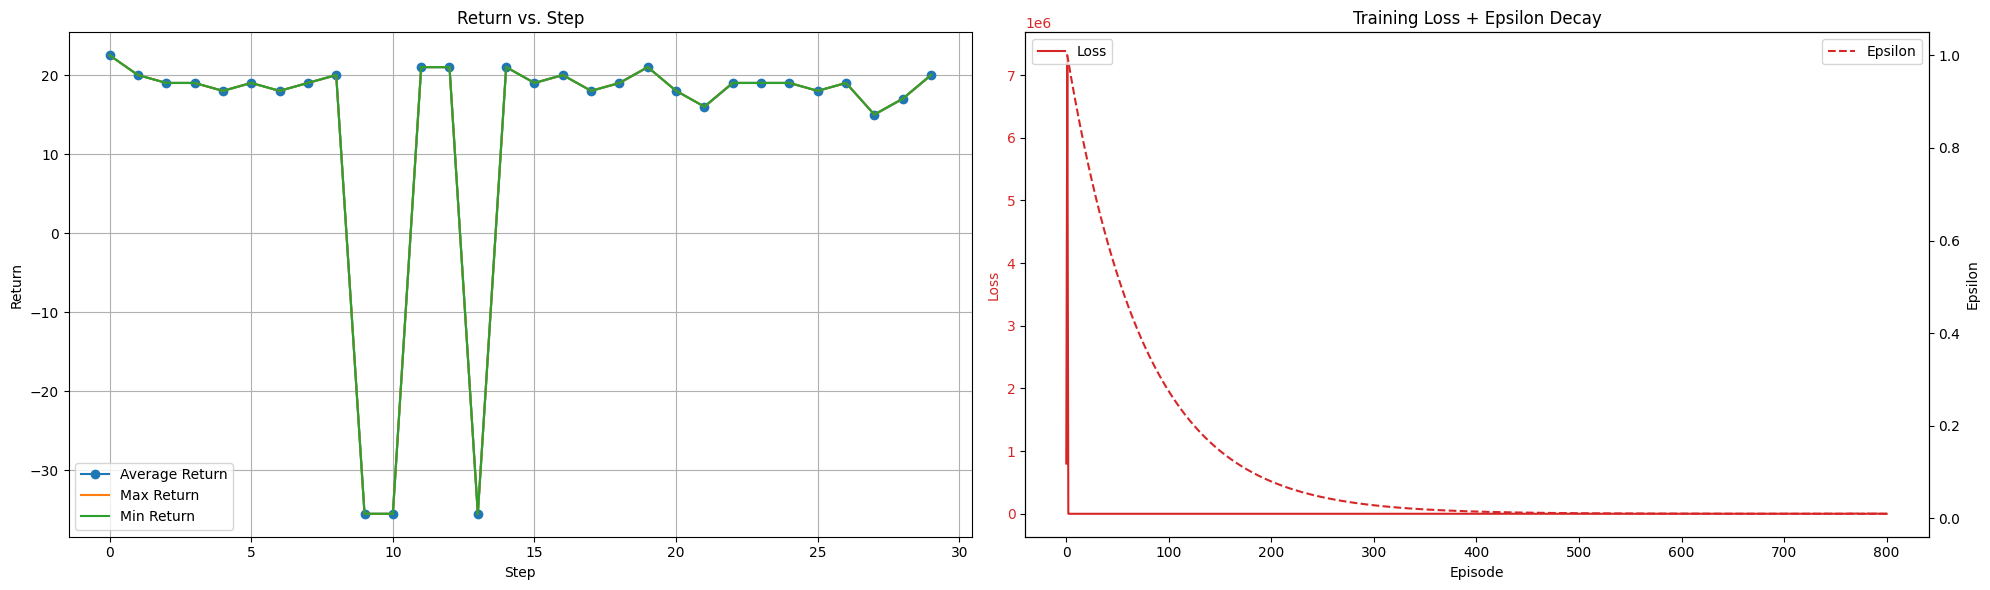

In [12]:
average_returns = [return_dict['AverageReturn'].numpy() for return_dict in returns]
min_returns = [return_dict['MinReturn'].numpy() for return_dict in returns]
max_returns = [return_dict['MaxReturn'].numpy() for return_dict in returns]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

steps = range(0, len(average_returns))
ax[0].plot(steps, average_returns, marker='o', label='Average Return')
ax[0].plot(steps, max_returns, label='Max Return')
ax[0].plot(steps, min_returns, label='Min Return')
ax[0].fill_between(steps, min_returns, max_returns, color='gray', alpha=0.3)  #
ax[0].set_ylabel('Return')
ax[0].set_xlabel('Step')
ax[0].set_title('Return vs. Step')
ax[0].grid(True)
ax[0].legend()

color = 'tab:red'
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Loss', color=color)
ax[1].plot(losses, color=color, label='Loss')
ax[1].tick_params(axis='y', labelcolor=color)

ax2 = ax[1].twinx()
ax2.set_ylabel('Epsilon')
ax2.plot(eps, color=color, linestyle='--', label='Epsilon')
ax2.tick_params(axis='y')
ax2.legend()
ax[1].set_title('Training Loss + Epsilon Decay')
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [13]:
if IN_COLAB:
    archive_path = shutil.make_archive("model_files", 'zip', root_dir='.', base_dir=f'{GDRIVE}/MyDrive/{policy_dir}')
    print(f"Archived {GDRIVE}/MyDrive/{archive_path}")
else:
    archive_path = shutil.make_archive("model_files", 'zip', root_dir='.', base_dir=policy_dir)
    print(f"Archived {policy_dir} into {archive_path}")

Archived ./models/policy into /kaggle/working/model_files.zip


In [14]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def eval_ts(env, policy_dir, name):
    print(f"Live episode started for {name}...")
    tf_eval_policy = tf.saved_model.load(policy_dir)
    tf_env = tf_py_environment.TFPyEnvironment(env)
    time_step = tf_env.reset()
    while not time_step.is_last():
        action_step = tf_eval_policy.action(time_step)
        time_step = tf_env.step(action_step.action)
    print("...Live episode finished")

    def numpy_int_handler(obj):
        if isinstance(obj, np.int64):
            return int(obj)
        raise TypeError("Unserializable object {} of type {}".format(obj, type(obj)))

    trade_stats  = env.get_trade_stats()
    file_path = os.path.join(policy_dir, f"{name}_trade_stats.json")
    with open(file_path, "w") as json_file:
        json.dumps(trade_stats, default=numpy_int_handler)

    print(f"Trade statistics saved to {file_path}")
    print(trade_stats)

    data = env.data.copy()
    data['Cumulative_Returns'] = np.cumprod(data["Returns"] + 1) - 1

    fig, axs = plt.subplots(3, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

    axs[0].plot(data.index, data[TARGET_FEATURE], label='Close', color='k', alpha=0.6)
    buys = data[data['Action'] == ACT_LONG]
    sells = data[data['Action'] == ACT_SHORT]
    axs[0].scatter(buys.index, buys[TARGET_FEATURE], label='Buy', color='green', marker='^', alpha=1)
    axs[0].scatter(sells.index, sells[TARGET_FEATURE], label='Sell', color='red', marker='v', alpha=1)
    axs[0].set_ylabel('Close ($)')
    axs[0].set_title(f'{name}: Actions + Close')
    axs[0].legend()

    axs[1].bar(data.index, data["Holdings"], label='Holdings', color='blue', alpha=0.4, width=0.15)
    axs[1].set_ylabel('Holdings')
    axs[1].set_title('Holdings')
    axs[1].legend()

    axs[2].plot(data.index, data['Cumulative_Returns'], label='Cumulative Returns', color='black')
    axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] >= 0), facecolor='green', alpha=0.3)
    axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] < 0), facecolor='red', alpha=0.3)
    axs[2].set_ylabel('Cumulative Returns')
    axs[2].set_title(f'{name} Cumulative Returns')
    axs[2].legend()

    ax12 = axs[0].twinx()
    reward_colors = ['green' if x >= 0 else 'red' for x in data['Reward']]
    ax12.bar(data.index, data['Reward'], color=reward_colors, label='Reward', alpha=0.5, width=0.005)
    ax12.set_ylabel('Reward')
    ax12.set_title(f'{name}: Reward')
    ax12.legend()

    hours_locator = mdates.HourLocator(interval=12)
    hours_formatter = mdates.DateFormatter('%d %H:%M')
    for ax in axs:
        ax.xaxis.set_major_locator(hours_locator)
        ax.xaxis.set_major_formatter(hours_formatter)

    fig.autofmt_xdate(rotation=45, ha='right')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

Live episode started for ^NDX...
...Live episode finished
Trade statistics saved to ./models/policy/^NDX_trade_stats.json
{'Annualized Return': 0.05291458146755985, 'Annualized Vol': 0.0491233351091529, 'Sharpe Ratio': 0.08393641181105736, 'Downside Deviation': 0.0407171379421298, 'Sortino Ratio': 0.00010046168745894781, 'Max Drawdown': -0.03165566022011366, 'Max Drawdown Days': 16, 'Trade Churn': 0.0, 'Skewness': 2.568326524735322, 'Kurtosis': 43.330261026550296}


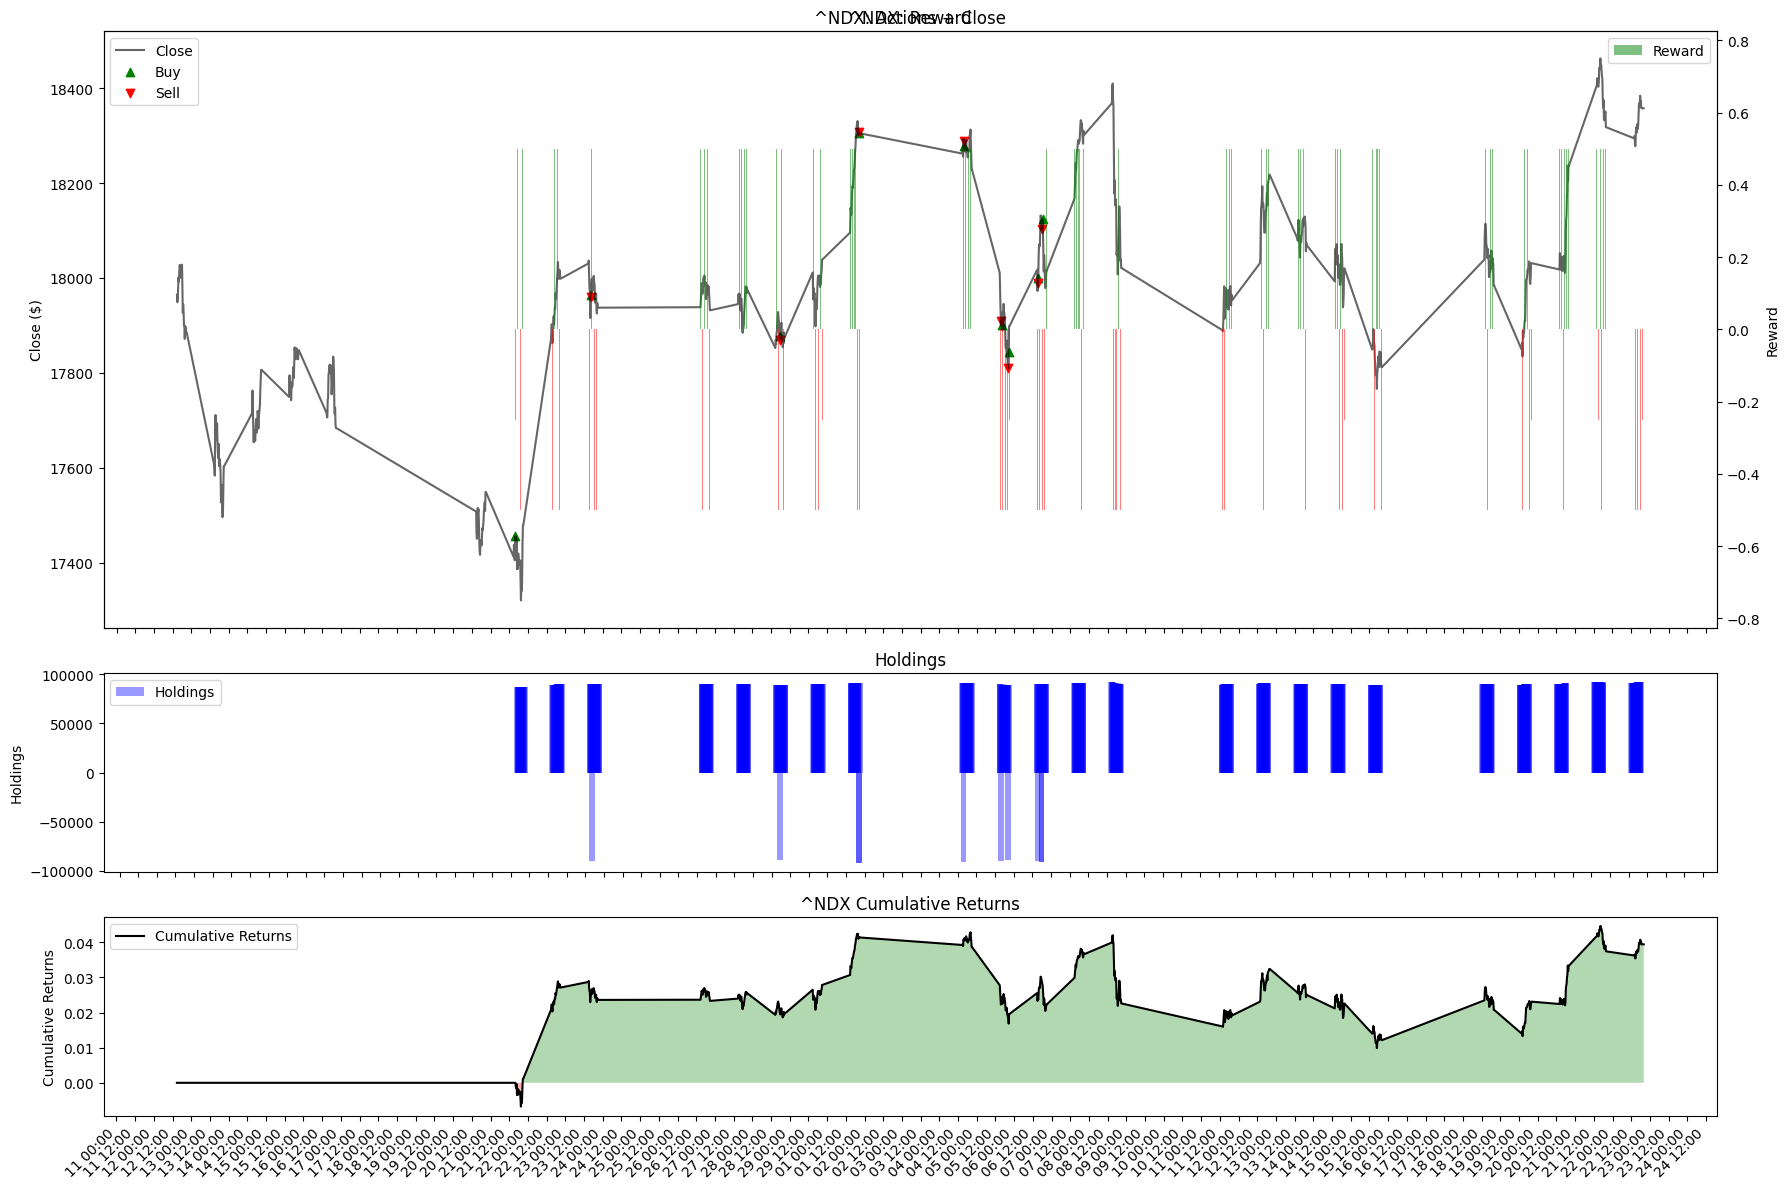

In [15]:
eval_ts(eval_env, policy_dir, TARGET1)

Live episode started for ^SPX...
...Live episode finished
Trade statistics saved to ./models/policy/^SPX_trade_stats.json
{'Annualized Return': -0.06962659501772249, 'Annualized Vol': 0.03768298671914155, 'Sharpe Ratio': -3.1424775557898132, 'Downside Deviation': 0.040280407111654606, 'Sortino Ratio': -0.002916507639899251, 'Max Drawdown': -0.03165566022011366, 'Max Drawdown Days': 16, 'Trade Churn': 0.0, 'Skewness': -3.5442224854342608, 'Kurtosis': 45.69706650015148}


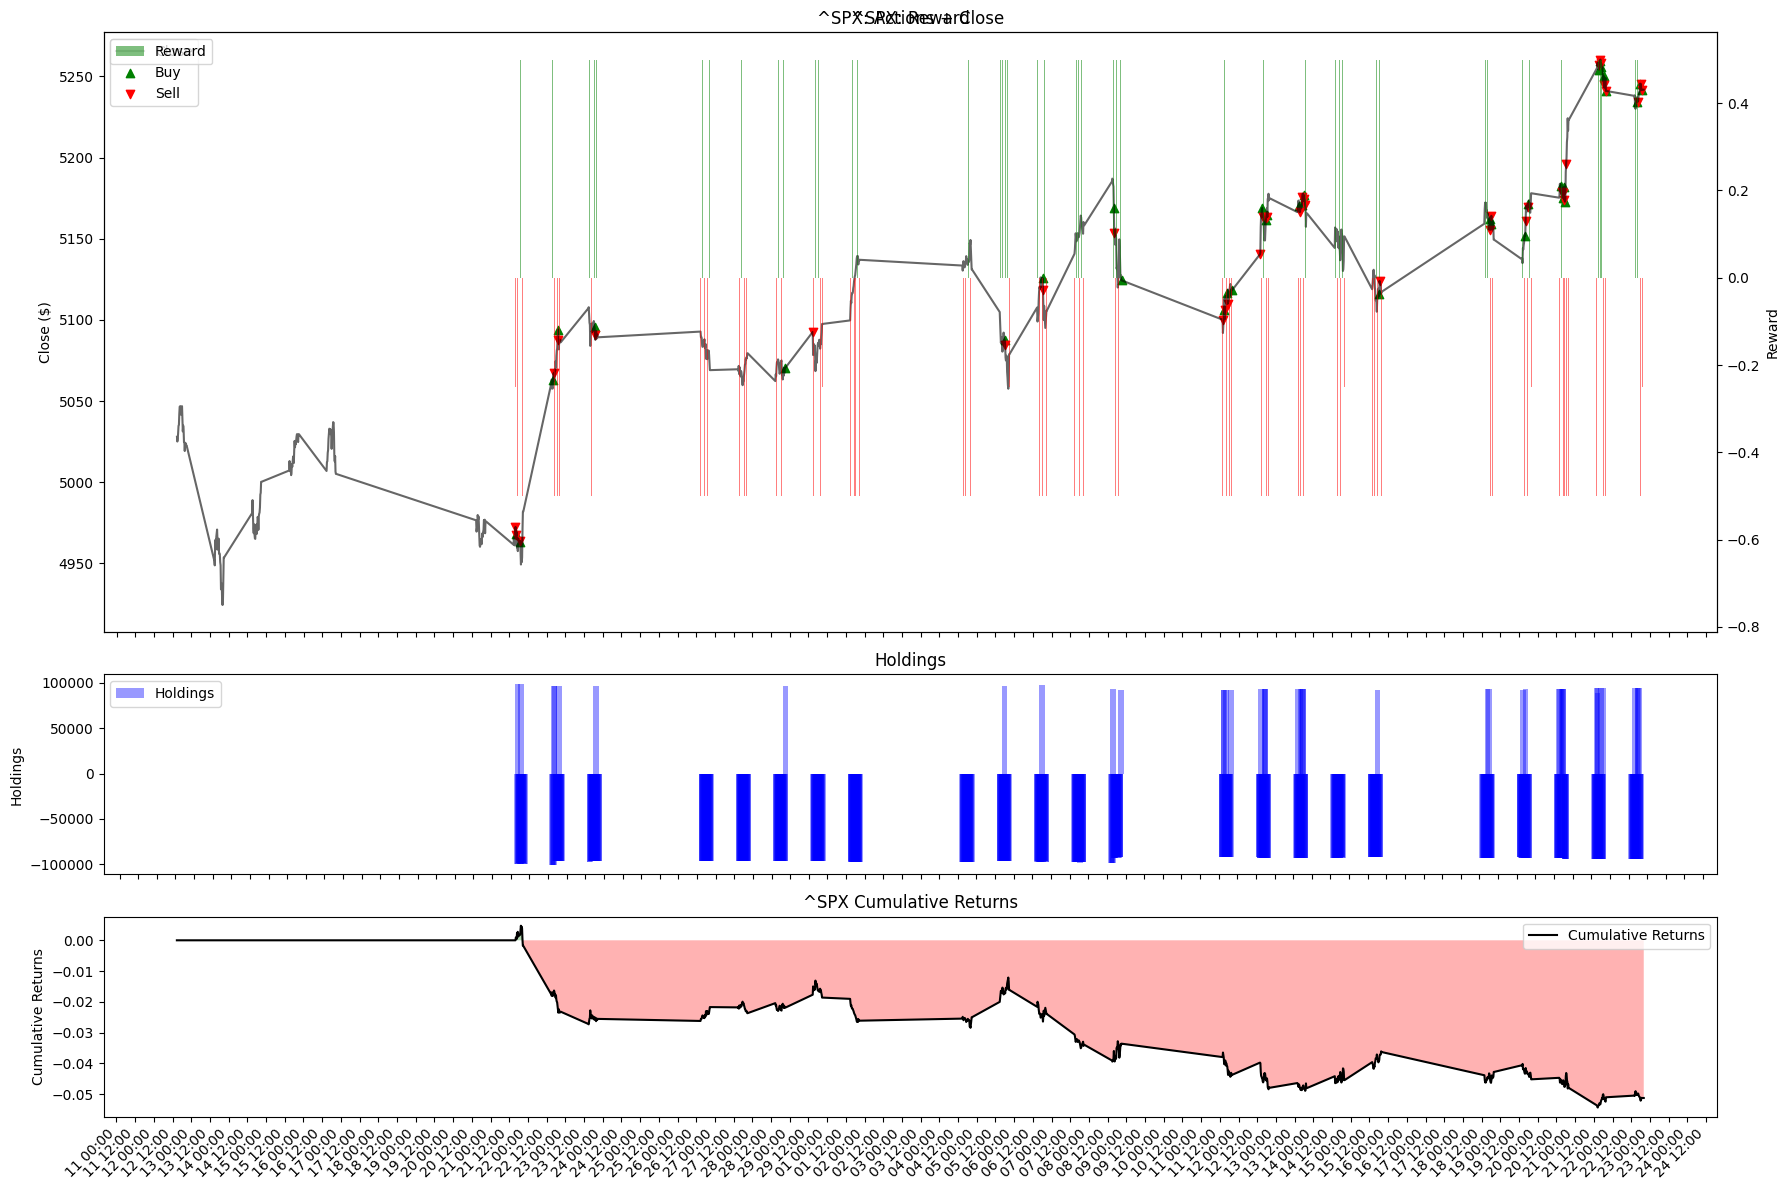

In [16]:
condition_eval_data = stock2_df[stock2_df.index >= SPLIT_DATE].copy()
condition_eval_env = TradingEnv(condition_eval_data)
utils.validate_py_environment(condition_eval_env, episodes=10)

eval_ts(condition_eval_env, policy_dir, TARGET2)

Live episode started for ^RUT...
...Live episode finished
Trade statistics saved to ./models/policy/^RUT_trade_stats.json
{'Annualized Return': 0.054957781446691646, 'Annualized Vol': 0.05253009267593511, 'Sharpe Ratio': 0.1173886462075703, 'Downside Deviation': 0.04086742227012788, 'Sortino Ratio': 0.000149691273699889, 'Max Drawdown': -0.03165566022011366, 'Max Drawdown Days': 16, 'Trade Churn': 0.0, 'Skewness': 1.5671934415380981, 'Kurtosis': 23.028482937497465}


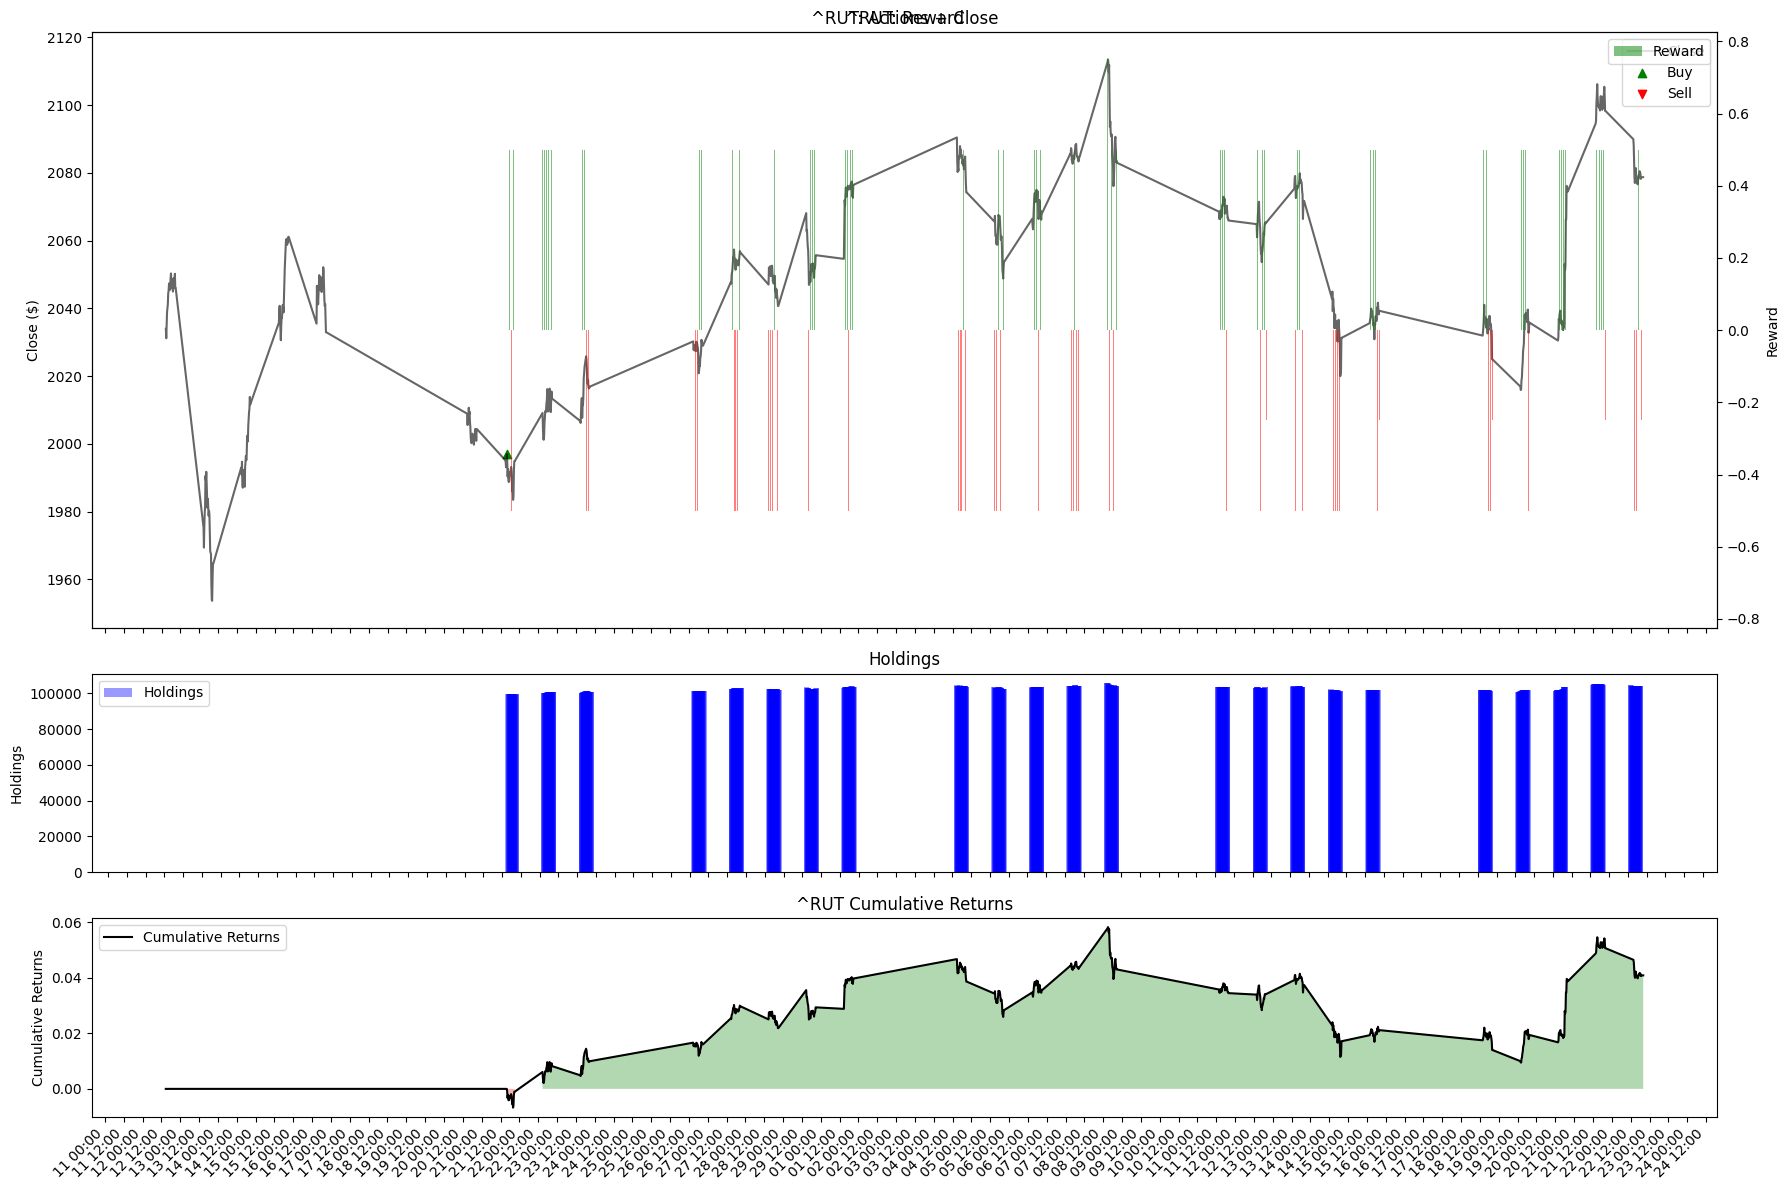

In [17]:
condition2_eval_data = stock3_df[stock3_df.index >= pd.to_datetime(SPLIT_DATE)].copy()
condition2_eval_env = TradingEnv(condition2_eval_data)
utils.validate_py_environment(condition2_eval_env, episodes=10)

eval_ts(condition2_eval_env, policy_dir, TARGET3)